In [11]:
# Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn

In [2]:
data = pd.read_csv("data/train.csv")

In [3]:
# Read data
def read_img(file_name):
    data = pd.read_csv("data/" + file_name)
    labels = data["label"].to_numpy()
    imgs = (data.iloc[:, 1:].to_numpy()).reshape((len(labels),28,28))
    return imgs, labels

In [4]:
# Split
imgs, labels = read_img("train.csv")
imgtrain, imgtest, labeltrain, labeltest = train_test_split(imgs, labels, test_size=.3)

In [5]:
class DigitDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [6]:
train_ds = DigitDataset(imgtrain, labeltrain)
test_ds = DigitDataset(imgtest, labeltest)

In [7]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 28, 28])
Labels batch shape: torch.Size([32])


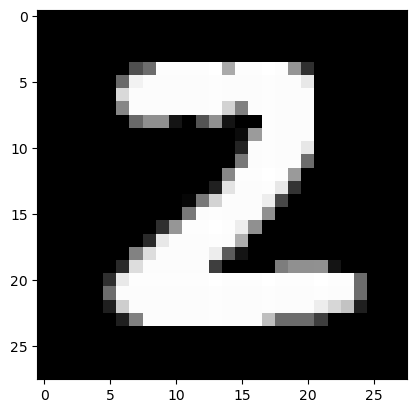

Label: 2


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [12]:
class TutorialNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
class DigitNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2dstack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5)),
            nn.Tanh(),
            nn.MaxPool2d((2,2)),
            nn.Tanh(),
            nn.Conv2d(6, 16, (5,5), groups=2),
            nn.Tanh(),
            nn.MaxPool2d((2,2)),
            nn.Tanh()
        )
        self.flatten = nn.Flatten()
        self.t1 = nn.Tanh()
        self.linear = nn.LazyLinear(100)
        self.t2 = nn.Tanh()
        self.output = nn.Linear(100, 10)
        self.softmax = nn.Softmax()


    def forward(self, x):
        x = self.conv2dstack(x)
        x = self.flatten(x)
        x = self.t1(x)
        x = self.linear(x)
        x = self.t2(x)
        x = self.output(x)
        logits = self.softmax(x)
        return logits